In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
%matplotlib inline

In [5]:
#Set the style for latex-like plots
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# Read results from pickles.
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
metrics = {}
timings = {}

for m in metrics_names:
    metrics[m] = {}
for s in seeds:
    with open("data/pkl/{seed}/precisions.pkl".format(seed=s), "rb") as f:
        metrics['precision'][s] = pickle.load(f)
    with open("data/pkl/{seed}/recalls.pkl".format(seed=s), "rb") as f:
        metrics['recall'][s] = pickle.load(f)
    with open("data/pkl/{seed}/f1_scores.pkl".format(seed=s), "rb") as f:
        metrics['f1_score'][s] = pickle.load(f)
    with open("data/pkl/{seed}/timings.pkl".format(seed=s), "rb") as f:
        timings[s] = pickle.load(f)

## Aggregate the results
Print some aggregated results for the last iteration only

In [11]:
# print metric/seed pair mean and stds
for metric in metrics_names:
    print("\nMetric: {}".format(metric.capitalize()))
    for s in seeds:
        metric_means, metric_stds = compute_mean_and_std_by_metric(metrics[metric][s])
        metric_mean, metric_std = metric_means.pop(), metric_stds.pop()
        # Print mean and std of the metric for the given seed (only last iteration printed for simplicity)
        print("    Seed:", str(float(s)*100)+"%")
        print("        Last Iteration Mean:", metric_mean)
        print("        Last Iteration Std:", metric_std)
# Print mean and std of timings
print("\nMetric: Running Time")
for s in seeds:
    print("    Seed:", str(float(s)*100)+"%")
    mean_timings = np.mean(timings[s])
    std_timings = np.std(timings[s])
    print("        Mean (s):", mean_timings/1000)
    print("        Std  (s):", std_timings/1000)


Metric: Precision
    Seed: 10.0%
        Last Iteration Mean: 0.9233009952766418
        Last Iteration Std: 0.004149546448537433
    Seed: 20.0%
        Last Iteration Mean: 0.9447710375986847
        Last Iteration Std: 0.002438021125866156
    Seed: 50.0%
        Last Iteration Mean: 0.9801147498188701
        Last Iteration Std: 0.0011171672043645434

Metric: Recall
    Seed: 10.0%
        Last Iteration Mean: 0.47795811925891335
        Last Iteration Std: 0.00660099552268535
    Seed: 20.0%
        Last Iteration Mean: 0.5754164720535575
        Last Iteration Std: 0.0046278719099872275
    Seed: 50.0%
        Last Iteration Mean: 0.7597189786704034
        Last Iteration Std: 0.0029181351539411754

Metric: F1_score
    Seed: 10.0%
        Last Iteration Mean: 0.6298300362902959
        Last Iteration Std: 0.005743956555303411
    Seed: 20.0%
        Last Iteration Mean: 0.715213864177381
        Last Iteration Std: 0.0038818424110766137
    Seed: 50.0%
        Last Iteration M

## Mean metric by iteration
Compute the mean of the measurements obtained for every metric and every seed, divided by the iteration.
Plot for all metrics and seeds the trend of the means, with error-bars.

In [12]:
def compute_mean_and_std_by_metric(metric):
    """
    Compute the mean and the standard deviation for each metric,
    grouped by every iteration of the algorithm.
    
    Args:
        metric (list): the name of the metric, among 'precision', 'recall' and 'f1_score' 
    Returns:
        metric_means (list): mean of the metric by iteration
        metric_stds (list): std of the metric by iteration
    """
    metric_means = []
    metric_stds = []
    # Get last iteration number
    last_iter = max(metric[0].keys()) + 1
    for i in range(last_iter):
        # Create a list of the values for iteration and compute mean/std
        iter_values = [val[i] for val in metric]
        metric_means.append(np.mean(iter_values))
        metric_stds.append(np.std(iter_values))
    return metric_means, metric_stds

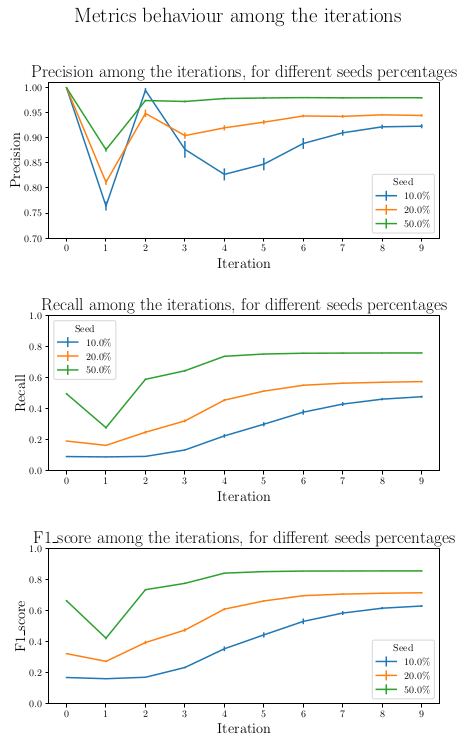

In [13]:
title = "{} among the iterations, for different seeds percentages"
fig, axarr = plt.subplots(3, 1, figsize=(7,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=0.5)
for i, metric in enumerate(metrics_names):
    for s in seeds:
        metric_means, metric_std = compute_mean_and_std_by_metric(metrics[metric][s])
        axarr[i].set_title(title.format(metric.capitalize()), fontsize=18)
        axes = plt.gca()
        if metric=="precision":
            axarr[i].set_ylim([0.7,1.01])
        else:
            axarr[i].set_ylim([0,1])
        axarr[i].set_xticks(range(10))
        axarr[i].set_xlabel("Iteration", fontsize=15)
        axarr[i].set_ylabel(metric.capitalize(), fontsize=15)
        axarr[i].errorbar(range(len(metric_means)), metric_means, yerr=metric_std, label=str(float(s)*100)+"%")
    axarr[i].legend(title="Seed")
fig.suptitle("Metrics behaviour among the iterations", y = 3.35, size=20);

## Time for seed
Plot the average time for every experiment, divided by seed in boxplots to analyze them

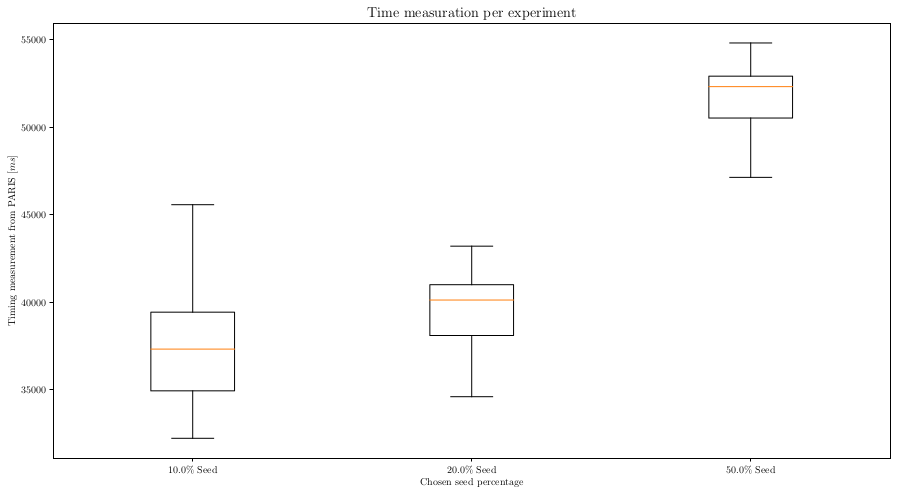

In [14]:
plt.figure(figsize=(15,8))
plt.title("Time measuration per experiment", fontsize=14)
plt.boxplot([timings[s] for s in seeds], labels=[str(float(s)*100)+"% Seed" for s in seeds])
plt.ylabel("Timing measurement from PARIS $[ ms ]$")
plt.xlabel("Chosen seed percentage");

## Confidence interval of last iteration's metrics
Plot the 95% confidence interval by bootstrapping the results obtained in the last iteration, for every metric and seed. The bootstrap is done by taking the list with the metric results (only last iteration for Precision, Recall, F1) and bootstraping it 1000 times. 

In [15]:
def bootstrap_metric(metric_list, n_iter):
    """Compute bootstrap means list for a metric to be used for computing confidence intervals
        using bootstrap resample
    Args:
        metric_list (list): The list (in the case of timings) or list of dicts of the given metric
        n_iter (int): number of sample to do for bootstrap

    Returns:
        means (list): list of n_iter means computed from the samples
    """
    means = []
    # For the Precision/Recall/F1 metrics use only the last iteration, for timings we don't have to consider this case
    if type(metric_list[0]) is dict:
        last_iter = max(metric_list[0].keys())
        metric_last = [val[last_iter] for val in metric_list]
    else:
        metric_last = metric_list
    
    # Resample and compute mean
    for _ in range(n_iter):
        # Bootstrap
        metric_sample = np.random.choice(metric_last, size=len(metric_last), replace=True)
        means.append(np.mean(metric_sample))

    return means

In [16]:
def confidence_interval(means, conf_percent):
    """Get confidence intervals for the given percentage by getting the quantiles

    Args:
        means (list): list of means computed from the samples
        conf_percent (float): Percentage for the confidence interval (between 0-1)

    Returns:
        [lower, upper] (list): the lower and upper bound of the confidence interval
    """
    # Computing low quantile 
    low_p = ((1.0 - conf_percent) / 2.0) * 100
    lower = np.percentile(means, low_p)

    # Computing high quantile
    high_p = (conf_percent + ((1.0 - conf_percent) / 2.0)) * 100
    upper = np.percentile(means, high_p)

    return [lower, upper]

In [17]:
def plot_confidence(means_metric, mean, interval, title, xlabel):
    """Plot a histogram with the confidence interval

    Args:
        means_metric (list): list of means computed from the samples
        mean (float): mean of the list
        interval (list): the lower and upper bound of the confidence interval
        title (str): Title for the plot
        xlabel (str): Label for the x axis
    """
    
    # Plot the means
    plt.hist(means_metric, bins=25)

    # Plot of two interval lines + mean line
    plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")

Confidence interval found for Precision - Seed 10.0%: [0.9214672056926674 - 0.9251401916834929]

Confidence interval found for Precision - Seed 20.0%: [0.9437221764773135 - 0.9458161938919974]

Confidence interval found for Precision - Seed 50.0%: [0.9796196166377744 - 0.9807028728181313]

Confidence interval found for Recall - Seed 10.0%: [0.4750890354974311 - 0.4810991748404173]

Confidence interval found for Recall - Seed 20.0%: [0.5733960960610306 - 0.5774132025533241]

Confidence interval found for Recall - Seed 50.0%: [0.7584069943951426 - 0.7609180873423635]

Confidence interval found for F1_score - Seed 10.0%: [0.627380390983028 - 0.6324545055998535]

Confidence interval found for F1_score - Seed 20.0%: [0.7135254629212752 - 0.7169413127040507]

Confidence interval found for F1_score - Seed 50.0%: [0.8550671963958917 - 0.8568240137517381]



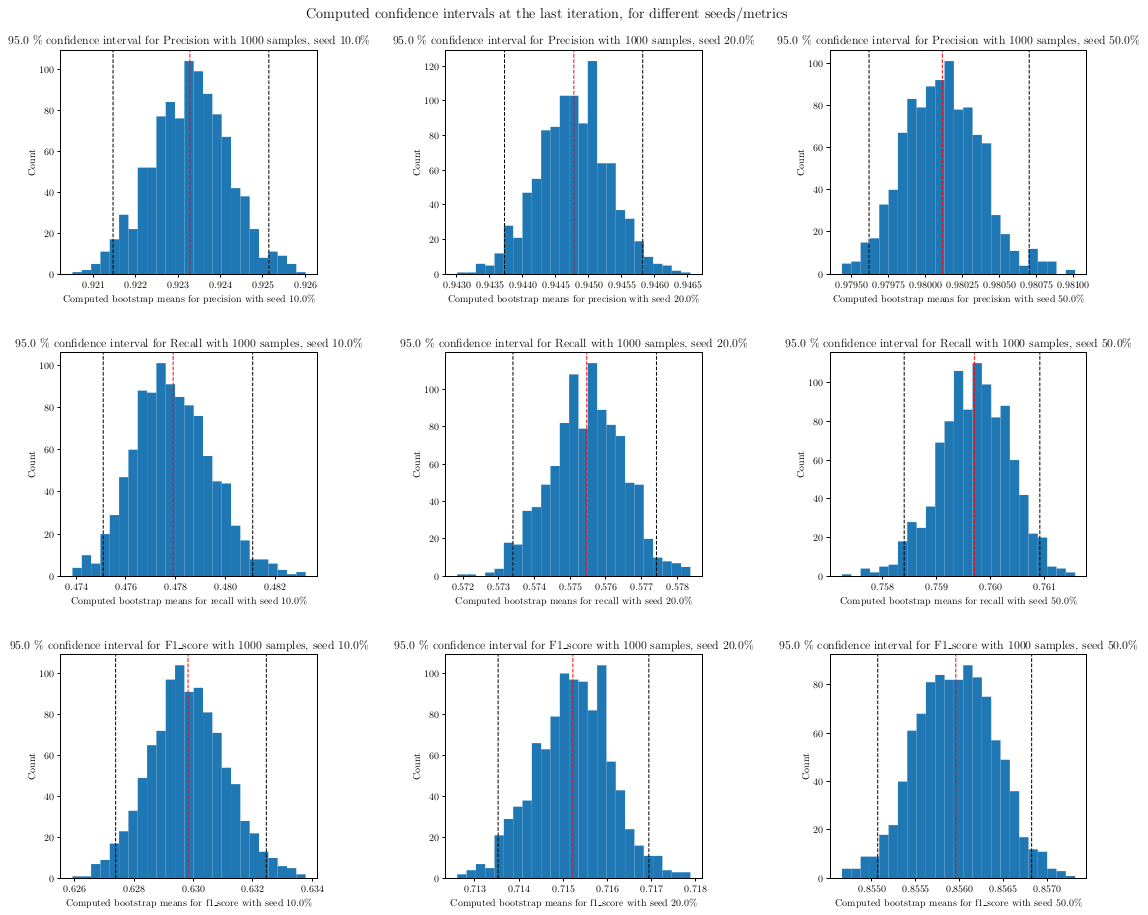

In [19]:
index = 1
fig, axarr = plt.subplots(3, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.5, hspace=0.35)

for m in metrics_names:
    for s in seeds:
        means_metric = bootstrap_metric(metrics[m][s], 1000)
        interval = confidence_interval(means_metric, 0.95)
        print("Confidence interval found for {metric} - Seed {seed}: [{low_inter} - {high_inter}]\n".format(metric=m.capitalize(), seed=str(float(s)*100)+"%", \
                                                                                                                low_inter=interval[0], high_inter=interval[1]))
        mean = np.mean(means_metric)
    
        plt.subplot(3, 3, index)
        plot_confidence(means_metric, mean, interval,\
                        "$95.0$ % confidence interval for {metric} with 1000 samples, seed {seed}".format(metric=m.capitalize(), seed = str(float(s)*100)+"%"),\
                        "Computed bootstrap means for {metric} with seed {seed}".format(metric=m, seed=str(float(s)*100)+"%"))
        index += 1 
fig.suptitle("Computed confidence intervals at the last iteration, for different seeds/metrics", y = 3.15, x=1.25, size=14);

## Confidence interval of timings
Plot the 95% confidence interval by bootstrapping the timing result, for each seed. The bootstrapping is done 1000 times also in this case, but there's no need to consider the last iteration only, as the timing is a global result

Confidence interval found for timings - Seed 10.0%: [35991.015 - 39092.54625]

Confidence interval found for timings - Seed 20.0%: [38678.64 - 40473.50874999999]

Confidence interval found for timings - Seed 50.0%: [50579.7675 - 52324.035]



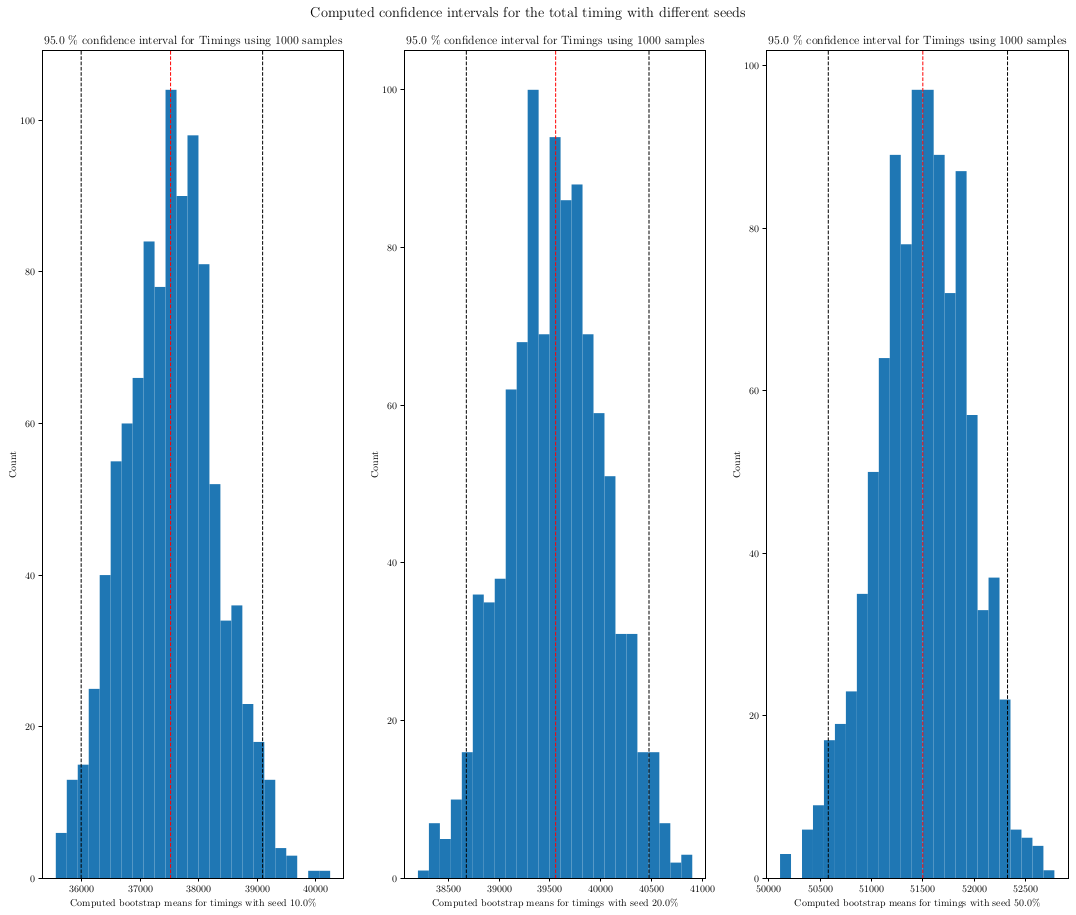

In [20]:
index = 1
fig, axarr = plt.subplots(1, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.2, hspace=0.35)

for s in seeds:
    means_timings = bootstrap_metric(timings[s], 1000)
    interval = confidence_interval(means_timings, 0.95)
    print("Confidence interval found for timings - Seed {seed}: [{low_inter} - {high_inter}]\n".format(seed=str(float(s)*100)+"%", \
                                                                                                        low_inter=interval[0], high_inter=interval[1]))
    mean = np.mean(means_timings)

    plt.subplot(1, 3, index)
    plot_confidence(means_timings, mean, interval,\
                    "$95.0$ % confidence interval for Timings using 1000 samples",\
                    "Computed bootstrap means for timings with seed {seed}".format(seed=str(float(s)*100)+"%"))
    index += 1 
fig.suptitle("Computed confidence intervals for the total timing with different seeds", y = 3.15, x=1.25, size=14);

## Plot the errors for last's iterations metrics
Plot the metrics obtained during the last iteration, for every metric and seed. This is done by boxplot, to later analyze the results goodness

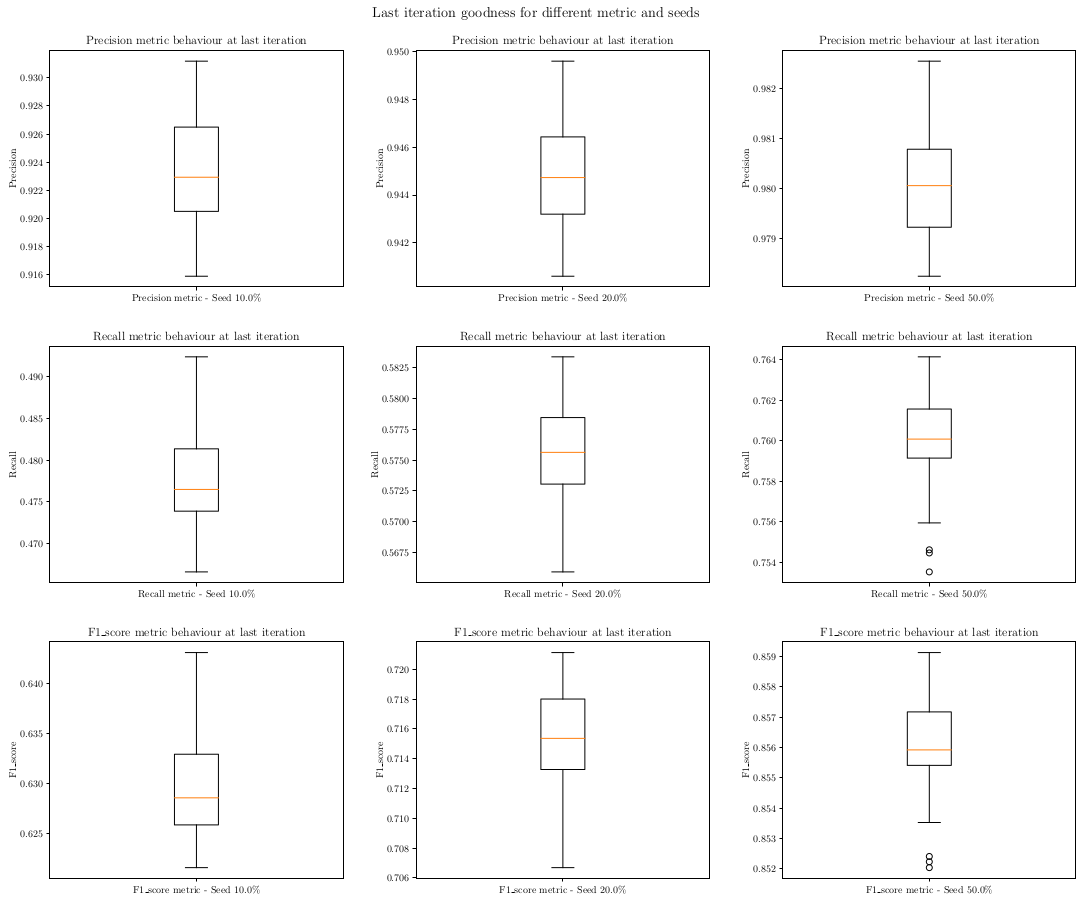

In [21]:
fig, axarr = plt.subplots(3, 3)
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.25, hspace=0.25)
metrics_names = ['precision', 'recall', 'f1_score']
seeds = ['0.1', '0.2', '0.5']

iterator = 1
for m in metrics_names:
    for s in seeds:
        last_iter = max(metrics[m][s][0].keys())
        metric_last = [val[last_iter] for val in metrics[m][s]]
        plt.subplot(3, 3, iterator)
        plt.boxplot([metric_last], labels=["{metric} metric - Seed {seed}".format(metric=m.capitalize(), seed=str(float(s)*100)+"%")])
        plt.ylabel(m.capitalize())
        plt.title("{} metric behaviour at last iteration".format(m.capitalize()))
        iterator += 1 
fig.suptitle("Last iteration goodness for different metric and seeds", y = 3.15, x=1.25, size=14);